In [62]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import seaborn as sns
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [106]:
#defining the subplot style for the barplots in questions 1 and 2
def setup_multiplot():
    fig = plt.figure(figsize=(20,5))
    ax1 = fig.add_subplot(121)
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=90)

    ax2 = fig.add_subplot(122)
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=90)
    return ax1, ax2

# Question 1

    Obtain the 200 top-ranking universities in www.topuniversities.com (ranking 2018). In particular, extract the following fields for each university: name, rank, country and region, number of faculty members (international and total) and number of students (international and total). Some information is not available in the main list and you have to find them in the details page. Store the resulting dataset in a pandas DataFrame and answer the following questions:

    Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?
    Answer the previous question aggregating the data by (c) country and (d) region.


### Scraping topuniversities.com
Scraping topuniversities is done in two steps:
- first we download the university list ordered by the ranking (the scraping_top_university_list)
- then we open each description page of the universities to get additional information (follow_detail_url_top_university)

follow_detail_url_top_university is quite a slow function, as it has to download many webpages (200 in our case).
To scrape all the information, execute: 
`follow_detail_url_top_university(scraping_top_university_list())`

In [2]:
TOP_UNIVERSITY_BASE_URL = "https://www.topuniversities.com"
TOP_UNIVERSITY_RANK_LIST_URL = TOP_UNIVERSITY_BASE_URL + "/sites/default/files/qs-rankings-data/357051.txt?_=1508344027292"
TOP_UNIVERSITY_NUMBER_OF_UNIVERSITIES_TO_SCRAPE = 200

def scraping_top_university_list():
    """
    This function downloads the university list rank from topuniversity.com and returns it in a list.
    Each element of the list is a simple dictionary containing: name, rank, country, region, and url
    to the detailed page of the university
    """
    top_university_ranking_page = requests.get(TOP_UNIVERSITY_RANK_LIST_URL)
    ranked_university_list = top_university_ranking_page.json()['data']
    data = [{
        'name': uni['title'],
        'rank': uni['rank_display'],
        'country': uni['country'],
        'region': uni['region'],
        'url': uni['url']
    } for uni in ranked_university_list[:TOP_UNIVERSITY_NUMBER_OF_UNIVERSITIES_TO_SCRAPE]]
    return data

ACADEMIC_STAFF_NUMBERS_REGEX = re.compile(r'^[^0-9,]*([0-9,]+)[^0-9,]*$')

def parse_top_university_numbers(text):
    """
    Just an utility function that let us parse to an integer the numbers scraped from the top universisty website
    """
    return int(ACADEMIC_STAFF_NUMBERS_REGEX.match(text).group(1).replace(',', ''))

def follow_detail_url_top_university(data):
    """
    This function takes as input a list returned by the 'scraping_top_university_list' function,
    follows the link of the url (giving detailed information on the university), and adds the
    number of faculty members (international and total) and the number of students (international and total).
    If some information is missing, it is filled with the None value
    """
    output = []
    for uni in data:
        try:
            raw_detail_page = requests.get(TOP_UNIVERSITY_BASE_URL + uni['url'])
            parsed_detail_page = BeautifulSoup(raw_detail_page.text, 'html.parser')
            try:
                members_total = parse_top_university_numbers(
                    parsed_detail_page.find('div', class_="total faculty").find(class_="number").text
                )
            except:
                members_total = None
            try:
                members_international = parse_top_university_numbers(
                    parsed_detail_page.find('div', class_="inter faculty").find(class_="number").text
                )
            except:
                members_international = None
            try:
                students_total = parse_top_university_numbers(
                    parsed_detail_page.find('div', class_="total student").find(class_="number").text
                )
            except:
                students_total = None
            try:
                students_international = parse_top_university_numbers(
                    parsed_detail_page.find('div', class_="total inter").find(class_="number").text
                )
            except:
                students_international = None
                
            output.append({
                'name': uni['name'],
                'rank': uni['rank'],
                'country': uni['country'],
                'region': uni['region'],
                'members_total': members_total,
                'members_international': members_international,
                'students_total': students_total,
                'students_international': students_international
            })
        except:
            print("Error loading details of university:", uni)
            output.append({
                'name': uni['name'],
                'rank': uni['rank'],
                'country': uni['country'],
                'region': uni['region'],
                'members_total': None,
                'members_international': None,
                'students_total': None,
                'students_international': None
            })
    return output

In [3]:
top_university_data = follow_detail_url_top_university(scraping_top_university_list())

In [4]:
top_university_data[11]

{'country': 'Switzerland',
 'members_international': 1300,
 'members_total': 1695,
 'name': 'Ecole Polytechnique Fédérale de Lausanne (EPFL)',
 'rank': '12',
 'region': 'Europe',
 'students_international': 5896,
 'students_total': 10343}

In [5]:
df_top_university = pd.DataFrame(top_university_data)

In [6]:
df_top_university[np.isnan(df_top_university.members_international)]

,country,members_international,members_total,name,rank,region,students_international,students_total
51,United States,NaN,NaN,New York University (NYU),52,North America,NaN,NaN
189,India,NaN,423.0,Indian Institute of Science (IISc) Bangalore,190,Asia,47.0,4071.0


In [7]:
df_top_university['ratio_faculty']=df_top_university['members_total'].div(df_top_university['students_total'])
df_top_university['ratio_international']=df_top_university['students_international'].div(df_top_university['students_total'])
df_top_university.head()

,country,members_international,members_total,name,rank,region,students_international,students_total,ratio_faculty,ratio_international
0,United States,1679.0,2982.0,Massachusetts Institute of Technology (MIT),1,North America,3717.0,11067.0,0.269450,0.335863
1,United States,2042.0,4285.0,Stanford University,2,North America,3611.0,15878.0,0.269870,0.227422
2,United States,1311.0,4350.0,Harvard University,3,North America,5266.0,22429.0,0.193945,0.234785
3,United States,350.0,953.0,California Institute of Technology (Caltech),4,North America,647.0,2255.0,0.422616,0.286918
4,United Kingdom,2278.0,5490.0,University of Cambridge,5,Europe,6699.0,18770.0,0.292488,0.356899


### By university

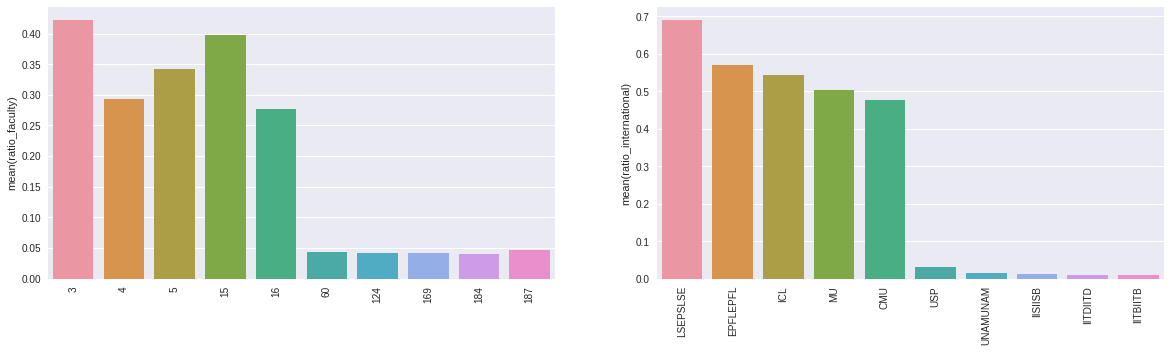

In [107]:
ax1,ax2=setup_multiplot()

top_fac=df_top_university.ratio_faculty.nlargest(n=5, keep='first')
bot_fac=df_top_university.ratio_faculty.nsmallest(n=5, keep='first')
bot_fac=bot_fac.sort_values(ascending=False)
s=top_fac.append(bot_fac)
idx=s.index
abv=pd.Series(index=s.index)
for idx in s.index:
    abv[idx]=re.sub('[^A-Z]', '', df_top_university.name[idx])
    
sns.barplot(s.index,s,ax=ax1)

top_int=df_top_university.ratio_international.nlargest(n=5, keep='first')
bot_int=df_top_university.ratio_international.nsmallest(n=5, keep='first')
bot_int=bot_int.sort_values(ascending=False)
s=top_int.append(bot_int)
idx=s.index
abv=pd.Series(index=s.index)
for idx in s.index:
    abv[idx]=re.sub('[^A-Z]', '', df_top_university.name[idx])
    
sns.barplot(abv,s, ax=ax2)

###  By country

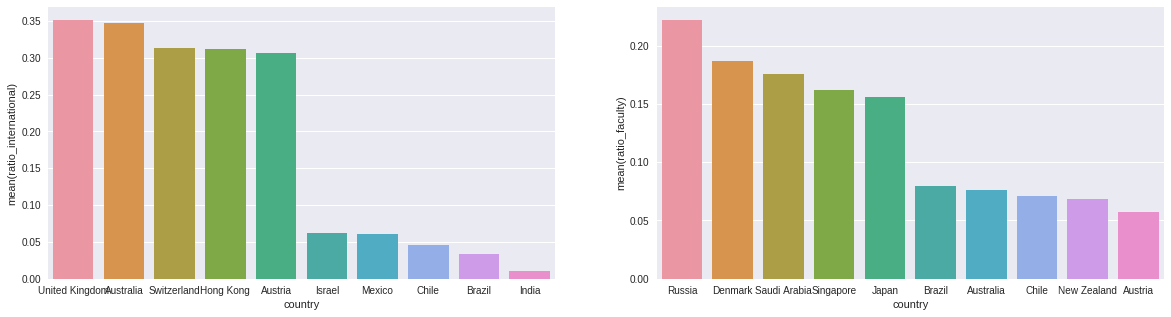

In [87]:
ax1,ax2=setup_multiplot()

grouped_country=df_top_university.groupby('country')
top_int=grouped_country.ratio_international.mean().nlargest(n=5)
bot_int=grouped_country.ratio_international.mean().nsmallest(n=5)
bot_int=bot_int.sort_values(ascending=False)
s=top_int.append(bot_int)

sns.barplot(s.index, s, ax=ax1)

top_fac=grouped_country.ratio_faculty.mean().nlargest(n=5)
bot_fac=grouped_country.ratio_faculty.mean().nsmallest(n=5)
bot_fac=bot_fac.sort_values(ascending=False)
s=top_fac.append(bot_fac)
sns.barplot(s.index, s, ax=ax2)

### By region

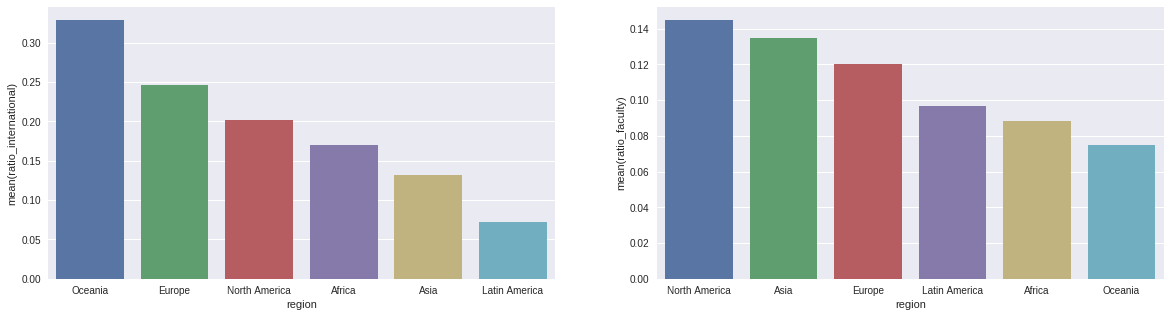

In [88]:
ax1,ax2=setup_multiplot()
grouped_region=df_top_university.groupby('region')

top_int=grouped_region.ratio_international.mean().nlargest(n=5)
bot_int=grouped_region.ratio_international.mean().nsmallest(n=5)
bot_int=bot_int.sort_values(ascending=False)
s=top_int.append(bot_int)

sns.barplot(s.index, s,ax=ax1)

top_fac=grouped_region.ratio_faculty.mean().nlargest(n=5)
bot_fac=grouped_region.ratio_faculty.mean().nsmallest(n=5)
bot_fac=bot_fac.sort_values(ascending=False)
s=top_fac.append(bot_fac)
sns.barplot(s.index, s,ax=ax2)


# Question 2
Obtain the 200 top-ranking universities in www.timeshighereducation.com (ranking 2018). Repeat the analysis of the previous point and discuss briefly what you observed.

### Scraping timeshighereducation.com
Scraping timeshighereducation.com can be done in one function this time. The detailed pages of the universities do not bring us more information. Unfortunatly, the region and number of international staff information is not given. To keep the same format as above, `scraping_higher_education_list` returns the same format but with `region` and `members_international` set to None. The number of international students and staff are not given either, but can be computed from the given stats. We set:

`members_total = number_of_staff_per_students/number_of_students`
`students_international = number_of_students * proportion_of_international_student`

In [89]:
HIGHER_EDUCATION_BASE_URL = "https://www.timeshighereducation.com"
HIGHER_EDUCATION_RANK_LIST_URL = HIGHER_EDUCATION_BASE_URL + \
    "/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json"
HIGHER_EDUCATION_NUMBER_OF_UNIVERSITIES_TO_SCRAPE = 200

HIGHER_EDUCATION_PERCENTAGE_REGEX = re.compile(r'^([0-9,.]+)%$')

def parse_higher_education_percentage(text):
    """
    Just an utility function that let us parse the percentage string from highereducation. It is returned as a float
    """
    return float(HIGHER_EDUCATION_PERCENTAGE_REGEX.match(text).group(1))/100.0

def scraping_higher_education_list():
    """
    This function downloads the university list rank from timeshighereducation.com and returns it in a list.
    Each element of the list is a simple dictionary containing: name, rank, country, region, the
    number of faculty members (international and total) and the number of students (international and total)
    """
    higher_education_ranking_page = requests.get(HIGHER_EDUCATION_RANK_LIST_URL)
    ranked_university_list = higher_education_ranking_page.json()['data']
    data = []
    for uni in ranked_university_list[:HIGHER_EDUCATION_NUMBER_OF_UNIVERSITIES_TO_SCRAPE]:
        number_of_students = int(uni['stats_number_students'].replace(',', ''))
        data.append({
            'name': uni['name'],
            'rank': uni['rank'],
            'country': uni['location'],
            'region': None,
            'members_total': int(float(number_of_students) / float(uni['stats_student_staff_ratio'])),
            'members_international': None,
            'students_total': number_of_students,
            'students_international': int(
                parse_higher_education_percentage(uni['stats_pc_intl_students']) * 
                float(number_of_students))
        })
    return data

In [90]:
higher_education_data = scraping_higher_education_list()

In [91]:
df_higher_education = pd.DataFrame(higher_education_data)

In [105]:
df_higher_education['ratio_faculty']=df_higher_education['members_total'].div(df_higher_education['students_total'])
df_higher_education['ratio_international']=df_higher_education['students_international'].div(df_higher_education['students_total'])
df_higher_education.head()

,country,members_international,members_total,name,rank,region,students_international,students_total,ratio_faculty,ratio_international
0,United Kingdom,None,1822,University of Oxford,1,None,7755,20409,0.089274,0.379979
1,United Kingdom,None,1687,University of Cambridge,2,None,6436,18389,0.091740,0.349992
2,United States,None,339,California Institute of Technology,=3,None,596,2209,0.153463,0.269805
3,United States,None,2112,Stanford University,=3,None,3485,15845,0.133291,0.219943
4,United States,None,1284,Massachusetts Institute of Technology,5,None,3800,11177,0.114879,0.339984


# By university

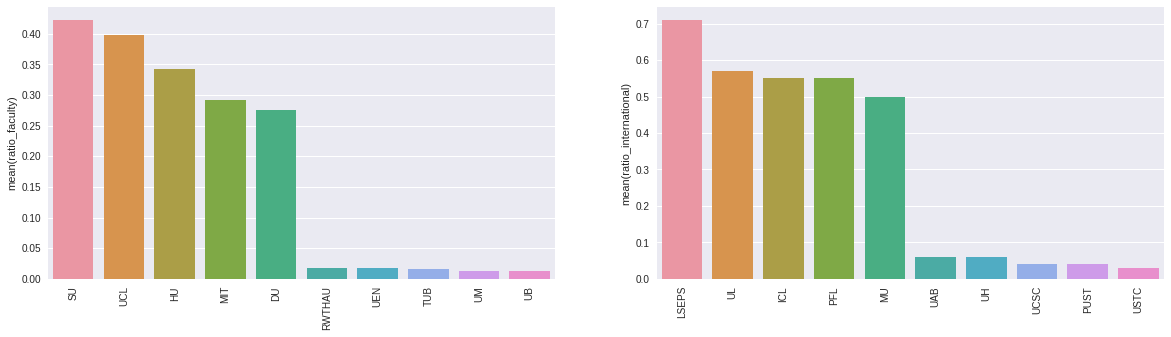

In [98]:
ax1,ax2=setup_multiplot()

top_fac=df_higher_education.ratio_faculty.nlargest(n=5, keep='first')
bot_fac=df_higher_education.ratio_faculty.nsmallest(n=5, keep='first')
bot_fac=bot_fac.sort_values(ascending=False)
s=top_u.append(bot_fac)
idx=s.index
abv=pd.Series(index=s.index)
for idx in s.index:
    abv[idx]=re.sub('[^A-Z]', '', df_higher_education.name[idx])
sns.barplot(abv,s,ax=ax1)

top_int=df_higher_education.ratio_international.nlargest(n=5, keep='first')
bot_int=df_higher_education.ratio_international.nsmallest(n=5, keep='first')
bot_int=bot_int.sort_values(ascending=False)
s=top_int.append(bot_int)
idx=s.index
abv=pd.Series(index=s.index)
for idx in s.index:
    abv[idx]=re.sub('[^A-Z]', '', df_higher_education.name[idx])
sns.barplot(abv,s,ax=ax2)


# By country

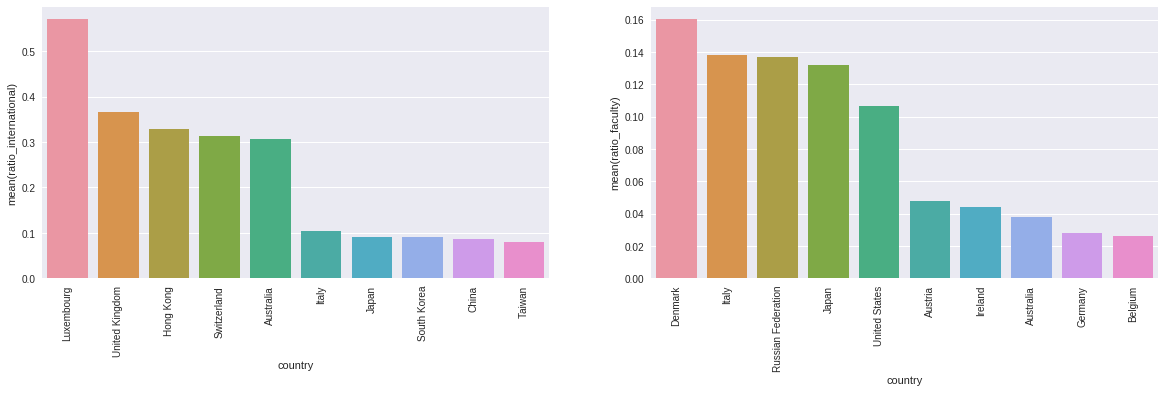

In [97]:
ax1,ax2=setup_multiplot()

grouped_country=df_higher_education.groupby('country')

top_int=grouped_country.ratio_international.mean().nlargest(n=5)
bot_int=grouped_country.ratio_international.mean().nsmallest(n=5)
bot_int=bot_int.sort_values(ascending=False)
s=top_int.append(bot_int)

sns.barplot(s.index, s,ax=ax1)

top_fac=grouped_country.ratio_faculty.mean().nlargest(n=5)
bot_fac=grouped_country.ratio_faculty.mean().nsmallest(n=5)
bot_fac=bot_fac.sort_values(ascending=False)
s=top_fac.append(bot_fac)
sns.barplot(s.index, s,ax=ax2)
#grouped_region=df_higher_education.groupby('region') Not defined for the second dataset (complete with the first ??)

# Question 3
Merge the two DataFrames created in questions 1 and 2 using university names. Match universities' names as well as you can, and explain your strategy. Keep track of the original position in both rankings

## Matching and merging the data

In [108]:
df_top_university_cp = df_top_university.copy()
df_higher_education_cp = df_higher_education.copy()
def remove_parentheses(value):
    value = re.sub(r'\([^)]*\)', '', value)
    value = value.strip()
    value = value.replace("  ", " ")
    return value
import unicodedata

def remove_special_chars(value):
    nfkd_form = unicodedata.normalize('NFKD', value)
    value = ''.join((c for c in nfkd_form if unicodedata.category(c) != 'Mn'))
    value = re.sub(r'[^a-zA-Z ]', ' ', value)
    return value


df_top_university_cp["name"] = df_top_university_cp["name"].apply(remove_special_chars)
df_top_university_cp["name"] = df_top_university_cp["name"].apply(remove_parentheses)
df_higher_education_cp["name"] = df_higher_education_cp["name"].apply(remove_special_chars)
df_top_university_cp.sort_values(by="name")

,country,members_international,members_total,name,rank,region,students_international,students_total,ratio_faculty,ratio_international
138,Finland,370.0,1257.0,Aalto University,=137,Europe,1831.0,12147.0,0.103482,0.150737
118,Denmark,602.0,2316.0,Aarhus University,119,Europe,3762.0,26226.0,0.088309,0.143445
170,Germany,413.0,1966.0,Albert Ludwigs Universitaet Freiburg,171,Europe,3897.0,23214.0,0.084690,0.167873
187,Italy,153.0,2990.0,Alma Mater Studiorum University of Bologna,=188,Europe,4195.0,63399.0,0.047162,0.066168
80,United States,379.0,3157.0,Boston University,81,North America,7041.0,25662.0,0.123022,0.274375
52,United States,379.0,1303.0,Brown University,53,North America,1825.0,9251.0,0.140850,0.197276
3,United States,350.0,953.0,California Institute of Technology Caltech,4,North America,647.0,2255.0,0.422616,0.286918
136,United Kingdom,705.0,2755.0,Cardiff University,=137,Europe,6090.0,24565.0,0.112151,0.247914
47,United States,425.0,1342.0,Carnegie Mellon University,=47,North America,6385.0,13356.0,0.100479,0.478062
176,France,137.0,529.0,CentraleSupelec,177,Europe,1132.0,3877.0,0.136446,0.291978


In [109]:
df_merged_data = pd.merge(df_top_university_cp, df_higher_education_cp, how="inner", on="name", left_index=False, right_index=False, copy=True)
df_merged_data

,country_x,members_international_x,members_total_x,name,rank_x,region_x,students_international_x,students_total_x,ratio_faculty_x,ratio_international_x,country_y,members_international_y,members_total_y,rank_y,region_y,students_international_y,students_total_y,ratio_faculty_y,ratio_international_y
0,United States,2042.0,4285.0,Stanford University,2,North America,3611.0,15878.0,0.269870,0.227422,United States,None,2112,=3,None,3485,15845,0.133291,0.219943
1,United States,1311.0,4350.0,Harvard University,3,North America,5266.0,22429.0,0.193945,0.234785,United States,None,2283,6,None,5284,20326,0.112319,0.259963
2,United Kingdom,2278.0,5490.0,University of Cambridge,5,Europe,6699.0,18770.0,0.292488,0.356899,United Kingdom,None,1687,2,None,6436,18389,0.091740,0.349992
3,United Kingdom,2964.0,6750.0,University of Oxford,6,Europe,7353.0,19720.0,0.342292,0.372870,United Kingdom,None,1822,1,None,7755,20409,0.089274,0.379979
4,United Kingdom,2071.0,3930.0,Imperial College London,8,Europe,8746.0,16090.0,0.244251,0.543567,United Kingdom,None,1390,8,None,8721,15857,0.087658,0.549978
5,United States,635.0,2449.0,University of Chicago,9,North America,3379.0,13557.0,0.180645,0.249244,United States,None,2181,9,None,3381,13525,0.161257,0.249982
6,United States,246.0,1007.0,Princeton University,13,North America,1793.0,8069.0,0.124799,0.222208,United States,None,958,7,None,1909,7955,0.120427,0.239975
7,United States,970.0,2718.0,Cornell University,14,North America,5411.0,21904.0,0.124087,0.247033,United States,None,2229,19,None,5244,21850,0.102014,0.240000
8,United States,1708.0,4940.0,Yale University,16,North America,2469.0,12402.0,0.398323,0.199081,United States,None,2826,12,None,2552,12155,0.232497,0.209955
9,United States,1061.0,4462.0,Johns Hopkins University,17,North America,4105.0,16146.0,0.276353,0.254243,United States,None,3604,13,None,3719,15498,0.232546,0.239966


In [110]:
df_do_not_match = pd.merge(df_top_university_cp, df_higher_education, how="outer", on="name", left_index=False, right_index=False, copy=True)
df_do_not_match.drop(df_do_not_match["name"].isin(df_merged_data["name"])).sort_values(by="name")

,country_x,members_international_x,members_total_x,name,rank_x,region_x,students_international_x,students_total_x,ratio_faculty_x,ratio_international_x,country_y,members_international_y,members_total_y,rank_y,region_y,students_international_y,students_total_y,ratio_faculty_y,ratio_international_y
138,Finland,370.0,1257.0,Aalto University,=137,Europe,1831.0,12147.0,0.103482,0.150737,Finland,None,630.0,190,None,2548.0,12744.0,0.049435,0.199937
118,Denmark,602.0,2316.0,Aarhus University,119,Europe,3762.0,26226.0,0.088309,0.143445,Denmark,None,1759.0,=109,None,3020.0,25167.0,0.069893,0.119998
170,Germany,413.0,1966.0,Albert Ludwigs Universitaet Freiburg,171,Europe,3897.0,23214.0,0.084690,0.167873,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187,Italy,153.0,2990.0,Alma Mater Studiorum University of Bologna,=188,Europe,4195.0,63399.0,0.047162,0.066168,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
258,NaN,NaN,NaN,Arizona State University,NaN,NaN,NaN,NaN,NaN,NaN,United States,None,2212.0,=126,None,8450.0,44475.0,0.049736,0.189994
222,NaN,NaN,NaN,Australian National University,NaN,NaN,NaN,NaN,NaN,NaN,Australia,None,828.0,48,None,5595.0,15986.0,0.051795,0.349994
267,NaN,NaN,NaN,Autonomous University of Barcelona,NaN,NaN,NaN,NaN,NaN,NaN,Spain,None,2504.0,=147,None,5169.0,32309.0,0.077502,0.159986
80,United States,379.0,3157.0,Boston University,81,North America,7041.0,25662.0,0.123022,0.274375,United States,None,2887.0,=70,None,6208.0,24833.0,0.116257,0.249990
52,United States,379.0,1303.0,Brown University,53,North America,1825.0,9251.0,0.140850,0.197276,United States,None,831.0,=50,None,1779.0,8898.0,0.093392,0.199933
200,NaN,NaN,NaN,California Institute of Technology,NaN,NaN,NaN,NaN,NaN,NaN,United States,None,339.0,=3,None,596.0,2209.0,0.153463,0.269805


# Question 4
Find useful insights in the data by performing an exploratory analysis. Can you find a strong correlation between any pair of variables in the dataset you just created? Example: when a university is strong in its international dimension, can you observe a consistency both for students and faculty members?

# Question 5
Can you find the best university taking in consideration both rankings? Explain your approach.